In [4]:
# Pandas
import pandas as pd

# Scikit learn
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle, resample
from sklearn.utils import class_weight
from sklearn.model_selection import cross_val_score

# Keras
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM
from keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.utils import to_categorical, np_utils
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint,TensorBoard,ProgbarLogger

# Audio
import librosa
import librosa.display
import wave
import IPython.display as ipd

# Plot
import matplotlib.pyplot as plt
import seaborn as sns

# Utility
import os
from glob import glob
import numpy as np
from tqdm import tqdm
import itertools
import numpy as np
from scipy.io import wavfile
import fnmatch

Using TensorFlow backend.


In [24]:
demographics = pd.read_csv('./Documents/respiratory-sound-database/demographic_info.txt', names = ['Patient number', 'Age', 'Sex' , 'Adult BMI (kg/m2)', 'Child Weight (kg)' , 'Child Height (cm)'], delimiter = ' ')

diagnosis = pd.read_csv('./Documents/respiratory-sound-database/patient_diagnosis.csv', names = ['Patient number', 'Diagnosis'])

COPD              64
Healthy           26
URTI              14
Bronchiectasis     7
Pneumonia          6
Bronchiolitis      6
LRTI               2
Asthma             1
Name: Diagnosis, dtype: int64


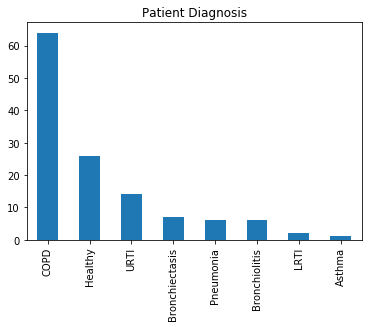

In [30]:
df = demographics.join(diagnosis.set_index('Patient number'), on = 'Patient number', how = 'left')
df['Patient_ID'] = df['Patient number']
print(df['Diagnosis'].value_counts())

df['Diagnosis'].value_counts().plot.bar(title = "Patient Diagnosis")

M    79
F    46
Name: Sex, dtype: int64


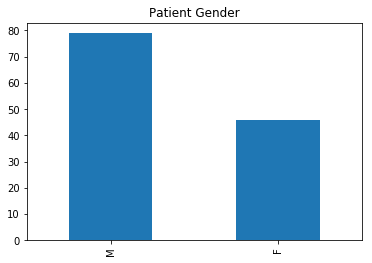

In [40]:
print(df['Sex'].value_counts())

df['Sex'].value_counts().plot.bar(title = "Patient Gender")

Average age: 42.99264 years
Youngest patient: 0.25 years
Oldest patient: 93.0 years


ValueError: cannot convert float NaN to integer

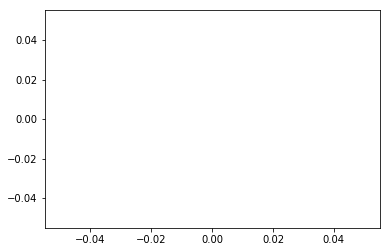

In [36]:
# Time Distribution
print("Average age:", np.mean(df['Age']), "years")
print("Youngest patient:", np.min(df['Age']), "years")
print("Oldest patient:", np.max(df['Age']), "years")

sns.distplot(df['Age'])

In [2]:
from datetime import datetime
from os import listdir
from os.path import isfile, join

mypath = "./Documents/respiratory-sound-database/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/"
filenames = [f for f in listdir(mypath) if (isfile(join(mypath, f)) and f.endswith('.wav'))]

In [5]:
patient_id = [] # patient IDs corresponding to each file
for name in filenames:
    patient_id.append(int(name[:3])) 

In [8]:
#Create artifact dataframe
sounds = pd.DataFrame()
sounds['Patient_ID'] = np.asarray(patient_id)

In [10]:
sounds.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 1 columns):
Patient_ID    920 non-null int32
dtypes: int32(1)
memory usage: 3.7 KB


In [11]:
#Function to get audio duration for each file
def get_recording_times(audio_files):
    data = []
    for file in audio_files:
        y, sr = librosa.load(file, res_type='kaiser_fast')
        dur = librosa.get_duration(y)
        data.append(dur)
    return data

In [12]:
#Function to get mel-frequency cepstral coefficient data for each file
def get_mfcc(audio_files):
    data = []
    for file in audio_files:
        y, sr = librosa.load(file, res_type='kaiser_fast')
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40) #sr = set of values at a point in time and/or space
        data.append(mfccs)
    return data

In [13]:
#Function to get mean mfccs for each file with a fix padding, may also chop off some file
def load_file_mfcc (folder,file_names, duration=10, sr=16000):
    input_length=sr*duration
    data = []
    for file_name in file_names:
        try:
            sound_file=folder+file_name
            X, sr = librosa.load( sound_file, sr=sr, duration=duration,res_type='kaiser_fast') 
            dur = librosa.get_duration(y=X, sr=sr)
            # pad audio file same duration
            if (round(dur) < duration):
                y = librosa.util.fix_length(X, input_length)
            mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sr, n_mfcc=40).T,axis=0)             
        except Exception as e:
            print("Error encountered while parsing file: ", file)        
        feature = np.array(mfccs).reshape([-1,1])
        data.append(feature)
    return data

In [14]:
#Function to get spectrogram data for each file with a fix padding, may also chop off some file
def load_file_spec (folder,file_names, duration=10, sr=16000):
    input_length=sr*duration
    data = []
    for file_name in file_names:
        try:
            sound_file=folder+file_name
            X, sr = librosa.load( sound_file, sr=sr, duration=duration,res_type='kaiser_fast') 
            dur = librosa.get_duration(y=X, sr=sr)
            # pad audio file same duration
            if (round(dur) < duration):
                y = librosa.util.fix_length(X, input_length)  
            spec_features = np.mean(librosa.amplitude_to_db(abs(librosa.stft(y)).T), axis=0)
        except Exception as e:
            print("Error encountered while parsing file: ", file_name) 
        data.append(spec_features)
    return data

In [15]:
# Function to flatten out spectrogram and mfcc data
# This is used to easily separate out that data into individual columns that will be used for supervised learning
def flat_(file):
    data=[]
    for x in file:
        flat = x.flatten()
        data.append(flat)
    return data

In [17]:
data = './Documents/audio_and_txt_files'
audio_files = glob(data + '/*.wav')
print("Number of audio files:", len(audio_files))

Number of audio files: 920


In [18]:
sounds['duration'] = np.asarray(get_recording_times(audio_files))

In [23]:
# parent folder of sound files
INPUT_DIR = "./Documents"
# 16 KHz
SAMPLE_RATE = 16000
# seconds
MAX_SOUND_CLIP_DURATION = 25

folder = INPUT_DIR+'/audio_and_txt_files/'

files = fnmatch.filter(os.listdir(INPUT_DIR+'/audio_and_txt_files/'), '*.wav')
sounds_spec = load_file_spec(folder=folder, file_names=files, duration=MAX_SOUND_CLIP_DURATION)

sounds['spec'] = sounds_spec

In [27]:
files = fnmatch.filter(os.listdir(INPUT_DIR+'/audio_and_txt_files/'), '*.wav')
sounds_mfcc = load_file_mfcc(folder=folder, file_names=files, duration=MAX_SOUND_CLIP_DURATION)

sounds['mean_mfccs'] = sounds_mfcc
sounds['mfccs_flat'] = flat_(sounds_mfcc)
sounds.head()

,Patient_ID,duration,spec,mean_mfccs,mfccs_flat
0,101,20.000000,"[8.123447, 12.025115, 11.816886, 8.981364, 5.7...","[[-515.6783], [113.95837], [71.15942], [42.378...","[-515.6783, 113.95837, 71.15942, 42.37833, 33...."
1,101,20.000000,"[5.7625904, 9.9406595, 8.972795, 5.579129, 3.6...","[[-572.6958], [103.28494], [56.087303], [30.84...","[-572.6958, 103.28494, 56.087303, 30.842743, 3..."
2,102,20.000000,"[3.959942, 6.6757374, 4.303745, 0.14441894, -2...","[[-580.9747], [121.591965], [56.966473], [25.9...","[-580.9747, 121.591965, 56.966473, 25.95974, 3..."
3,103,20.000000,"[23.06911, 29.05004, 26.390932, 17.75523, 12.2...","[[-408.96204], [71.44204], [48.838448], [34.06...","[-408.96204, 71.44204, 48.838448, 34.060986, 3..."
4,104,15.856009,"[1.8390962, 3.4313285, 4.312777, 4.5215893, 3....","[[-436.71918], [116.14284], [77.762695], [38.0...","[-436.71918, 116.14284, 77.762695, 38.06044, 1..."


In [31]:
final = sounds.join(df.set_index('Patient_ID'), on = 'Patient_ID', how = 'left')

In [37]:
final.head()

,Patient_ID,duration,spec,mean_mfccs,mfccs_flat,Patient number,Age,Sex,Adult BMI (kg/m2),Child Weight (kg),Child Height (cm),Diagnosis
0,101,20.000000,"[8.123447, 12.025115, 11.816886, 8.981364, 5.7...","[[-515.6783], [113.95837], [71.15942], [42.378...","[-515.6783, 113.95837, 71.15942, 42.37833, 33....",101,3.00,F,NaN,19.0,99.0,URTI
1,101,20.000000,"[5.7625904, 9.9406595, 8.972795, 5.579129, 3.6...","[[-572.6958], [103.28494], [56.087303], [30.84...","[-572.6958, 103.28494, 56.087303, 30.842743, 3...",101,3.00,F,NaN,19.0,99.0,URTI
2,102,20.000000,"[3.959942, 6.6757374, 4.303745, 0.14441894, -2...","[[-580.9747], [121.591965], [56.966473], [25.9...","[-580.9747, 121.591965, 56.966473, 25.95974, 3...",102,0.75,F,NaN,9.8,73.0,Healthy
3,103,20.000000,"[23.06911, 29.05004, 26.390932, 17.75523, 12.2...","[[-408.96204], [71.44204], [48.838448], [34.06...","[-408.96204, 71.44204, 48.838448, 34.060986, 3...",103,70.00,F,33.00,NaN,NaN,Asthma
4,104,15.856009,"[1.8390962, 3.4313285, 4.312777, 4.5215893, 3....","[[-436.71918], [116.14284], [77.762695], [38.0...","[-436.71918, 116.14284, 77.762695, 38.06044, 1...",104,70.00,F,28.47,NaN,NaN,COPD


In [35]:
final.Diagnosis.value_counts()

COPD              793
Pneumonia          37
Healthy            35
URTI               23
Bronchiectasis     16
Bronchiolitis      13
LRTI                2
Asthma              1
Name: Diagnosis, dtype: int64

Average recording time: 21.492426353149952 seconds
Smallest recording time: 7.8560090702947845 seconds
Longest recording time: 86.2 seconds


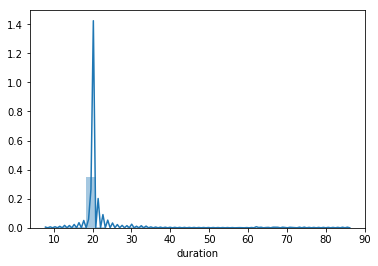

In [26]:
# Time Distribution
print("Average recording time:", np.mean(sounds['duration']), "seconds")
print("Smallest recording time:", np.min(sounds['duration']), "seconds")
print("Longest recording time:", np.max(sounds['duration']), "seconds")

sns.distplot(sounds['duration'])

In [ ]:
#Healthy
ipd.Audio(audio_files[3])

In [ ]:
#COPD
ipd.Audio(audio_files[3])

In [ ]:
#URTI
ipd.Audio(audio_files[3])

In [ ]:
#Pneumonia
ipd.Audio(audio_files[3])

In [ ]:
#waveplots
# librosa plot -- set-a
plt.figure(figsize=(16, 8))

plt.subplot(3, 1, 1)
y, sr = librosa.load(audio_files_a[9])
librosa.display.waveplot(y, sr=sr)
plt.title("Normal Heart")

plt.subplot(3, 1, 2)
y, sr = librosa.load(audio_files_a[10])
librosa.display.waveplot(y, sr=sr)
plt.title("Abnormal Heart")

plt.subplot(3, 1, 3)
y, sr = librosa.load(audio_files_artifacts[3])
librosa.display.waveplot(y, sr=sr)
plt.title("Artifact")

plt.tight_layout()
plt.show()

In [ ]:
# Spectrograms
# librosa spectrogram plot -- set-a
plt.figure(figsize=(20, 8))

plt.subplot(3, 1, 1)
y, sr = librosa.load(audio_files_a[9])
D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
librosa.display.specshow(D, x_axis='time', y_axis='log')
plt.title("Normal Heart Spectrogram")

plt.subplot(3, 1, 2)
y, sr = librosa.load(audio_files_a[10])
D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
librosa.display.specshow(D, x_axis='time', y_axis='log')
plt.title("Abnormal Heart Spectrogram")

plt.subplot(3, 1, 3)
y, sr = librosa.load(audio_files_artifacts[3])
D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
librosa.display.specshow(D, x_axis='time', y_axis='log')
plt.title("Artifact Spectrogram")

plt.tight_layout()
plt.show()

NameError: name 'audio_files_a' is not defined

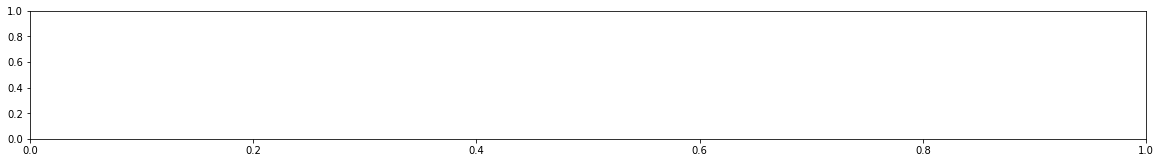

In [41]:
# MFCCs
# librosa mfcc plot -- set-a
plt.figure(figsize=(20, 8))

plt.subplot(3, 1, 1)
y, sr = librosa.load(audio_files_a[9])
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
librosa.display.specshow(mfccs, x_axis='time', y_axis='log')
plt.colorbar()
plt.title('Normal Heart (MFCCs)')

plt.subplot(3, 1, 2)
y, sr = librosa.load(audio_files_a[10])
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
librosa.display.specshow(mfccs, x_axis='time', y_axis='log')
plt.colorbar()
plt.title('Abormal Heart (MFCCs)')

plt.subplot(3, 1, 3)
y, sr = librosa.load(audio_files_artifacts[3])
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
librosa.display.specshow(mfccs, x_axis='time', y_axis='log')
plt.colorbar()
plt.title('Artifact (MFCCs)')

plt.tight_layout()
plt.show()

In [42]:
#spread out spec data for input into models
mean_spec = final['spec'].apply(pd.Series)
mean_spec = mean_spec.rename(columns = lambda x : 'spec_' + str(x))
mean_spec.head()

,spec_0,spec_1,spec_2,spec_3,spec_4,spec_5,spec_6,spec_7,spec_8,spec_9,...,spec_1015,spec_1016,spec_1017,spec_1018,spec_1019,spec_1020,spec_1021,spec_1022,spec_1023,spec_1024
0,8.123447,12.025115,11.816886,8.981364,5.779897,4.188724,2.528362,-0.755070,-2.653456,-3.316959,...,-42.535259,-42.535275,-42.535282,-42.535301,-42.535301,-42.535301,-42.535301,-42.535313,-42.535320,-42.535328
1,5.762590,9.940660,8.972795,5.579129,3.610048,1.060689,-1.936463,-5.274032,-8.373034,-10.520452,...,-41.750599,-41.750626,-41.750622,-41.750664,-41.750664,-41.750664,-41.750656,-41.750668,-41.750694,-41.750664
2,3.959942,6.675737,4.303745,0.144419,-2.258024,-4.340283,-7.488881,-10.965380,-12.695719,-13.499794,...,-46.575901,-46.575901,-46.575893,-46.575893,-46.575909,-46.575916,-46.575909,-46.575897,-46.575886,-46.575882
3,23.069111,29.050039,26.390932,17.755230,12.274289,6.872453,3.626569,1.385379,-0.608749,-2.251781,...,-25.977005,-25.977005,-25.977015,-25.977015,-25.977022,-25.977024,-25.977024,-25.977022,-25.977024,-25.977034
4,1.839096,3.431329,4.312777,4.521589,3.589658,1.643603,-0.726662,-2.173375,-3.377479,-5.078349,...,-30.126284,-30.126284,-30.126284,-30.126284,-30.126284,-30.126284,-30.126284,-30.126284,-30.126284,-30.126284


In [46]:
from sklearn.preprocessing import StandardScaler
X = mean_spec
target = final['Diagnosis']
X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, target, train_size = 0.75)

C:\Users\mike1\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\mike1\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\mike1\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [48]:
# Logistic Regression Model - spectrogram
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, class_weight=None, random_state=None, solver='newton-cg', max_iter=100, multi_class='auto', verbose=0, warm_start=False, n_jobs=None)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(cross_val_score(lr, X, target, cv = 5))

0.9043478260869565
[[  0   0   0   0   0   0   0]
 [  0   2   0   0   0   0   0]
 [  0   0   0   2   3   0   0]
 [  0   0   0 197   1   1   0]
 [  0   0   2   3   5   1   0]
 [  0   0   0   4   0   4   0]
 [  1   0   0   4   0   0   0]]


C:\Users\mike1\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


[0.81382979 0.86021505 0.9076087  0.90607735 0.80110497]


In [49]:
# KNN model - spectrogram
from sklearn.neighbors import KNeighborsClassifier

neighbors = KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='auto', leaf_size=30, p=2, metric='minkowski', metric_params=None, n_jobs=None)
neighbors.fit(X_train, y_train)
y_pred = neighbors.predict(X_test)

print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(cross_val_score(neighbors, X, target, cv = 5))

0.8652173913043478
[[  0   0   0   0   0   0   0]
 [  0   0   0   2   0   0   0]
 [  1   1   0   2   0   0   1]
 [  0   0   0 199   0   0   0]
 [  0   1   1   7   0   1   1]
 [  0   0   0   8   0   0   0]
 [  0   0   0   5   0   0   0]]


C:\Users\mike1\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


[0.81382979 0.75268817 0.875      0.82872928 0.80110497]


In [50]:
# Random Forest Model - spectrogram
from sklearn import ensemble

rfc = ensemble.RandomForestClassifier(n_estimators=150, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, class_weight='balanced')
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)

print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(cross_val_score(rfc, X, target, cv = 5))

0.8434782608695652
[[  1   0   1   0   0   0]
 [  1   0   4   0   0   0]
 [  2   0 191   3   0   3]
 [  0   1   6   0   2   2]
 [  0   0   6   0   2   0]
 [  0   0   5   0   0   0]]


C:\Users\mike1\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


[0.84042553 0.80645161 0.88586957 0.86187845 0.85635359]


In [51]:
# Gradient Boosting Model -- spectrogram
gb = ensemble.GradientBoostingClassifier(loss='deviance', learning_rate=0.1, n_estimators=100, subsample=1.0, criterion='friedman_mse', min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_depth=3, min_impurity_decrease=0.0, min_impurity_split=None, init=None, random_state=None, max_features='auto', verbose=0, max_leaf_nodes=None, warm_start=False, presort='auto', validation_fraction=0.1, n_iter_no_change=None, tol=0.0001)
gb.fit(X_train, y_train)

print(accuracy_score(y_test, gb.predict(X_test)))
print(confusion_matrix(y_test, y_pred))
print(cross_val_score(gb, X, target, cv = 5))

0.9
[[  1   0   1   0   0   0]
 [  1   0   4   0   0   0]
 [  2   0 191   3   0   3]
 [  0   1   6   0   2   2]
 [  0   0   6   0   2   0]
 [  0   0   5   0   0   0]]


C:\Users\mike1\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


[0.84042553 0.84408602 0.90217391 0.85635359 0.83977901]


In [52]:
#spread out mfcc data for input into models
mean_mfcc = final['mfccs_flat'].apply(pd.Series)
mean_mfcc = mean_mfcc.rename(columns = lambda x : 'mean_mfcc_' + str(x))
mean_mfcc.head()

,mean_mfcc_0,mean_mfcc_1,mean_mfcc_2,mean_mfcc_3,mean_mfcc_4,mean_mfcc_5,mean_mfcc_6,mean_mfcc_7,mean_mfcc_8,mean_mfcc_9,...,mean_mfcc_30,mean_mfcc_31,mean_mfcc_32,mean_mfcc_33,mean_mfcc_34,mean_mfcc_35,mean_mfcc_36,mean_mfcc_37,mean_mfcc_38,mean_mfcc_39
0,-515.678284,113.958366,71.159416,42.378330,33.491215,28.343691,20.493902,16.771233,18.421787,16.688015,...,1.085946,1.420841,1.723369,1.759100,1.764396,1.900784,2.010527,1.875236,1.505518,1.274461
1,-572.695801,103.284943,56.087303,30.842743,33.551819,37.284496,28.702307,19.017298,16.912680,15.512327,...,1.518936,2.742966,3.569757,3.054491,2.110286,2.256540,3.312136,3.682358,2.659006,1.143951
2,-580.974670,121.591965,56.966473,25.959740,34.997261,43.360134,28.370544,6.880596,-0.109614,5.383647,...,3.356558,2.354979,1.213654,2.023259,3.549309,3.411893,2.199108,2.197356,3.192662,3.001633
3,-408.962036,71.442039,48.838448,34.060986,30.043154,26.994886,21.588650,17.744015,16.413185,14.409512,...,4.353942,3.911645,3.508018,2.967844,2.514060,2.373760,2.389124,2.494671,2.924427,3.568199
4,-436.719177,116.142838,77.762695,38.060440,12.855058,4.526144,6.410844,11.374701,15.793918,18.486288,...,2.650678,3.115096,3.483489,3.912178,4.325048,4.441020,4.091199,3.439331,2.799393,2.289464


In [53]:
X = mean_mfcc
target = final['Diagnosis']
X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, target, train_size = 0.75)

C:\Users\mike1\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\mike1\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\mike1\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
